## Neural Network for Fast Label free Nanoscale Composition discovery of Eukaryotic Cells

Code by: Marti Checa

Publication: M.Checa et. al "Fast Label-Free Nanoscale Composition Mapping of Eukaryotic Cells Via Scanning Dielectric Force Volume Microscopy and Machine Learning", Small Methods (2021)

## Imports

In [1]:
# Load Libraries
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.cluster import KMeans
import numpy as np
import time
import math
from sklearn.cluster import KMeans
from scipy import interpolate
from sklearn import decomposition
from scipy import ndimage
from sklearn import preprocessing

## Loading the data and generating input images for the NN

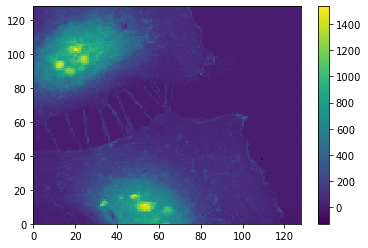

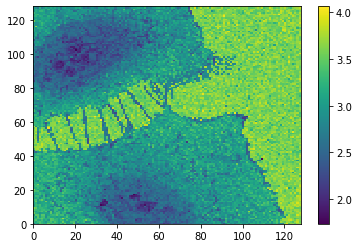

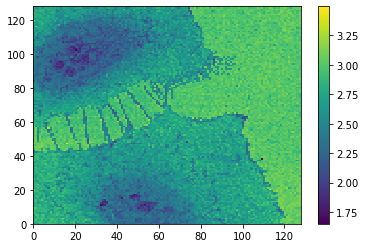

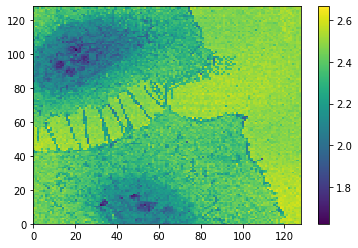

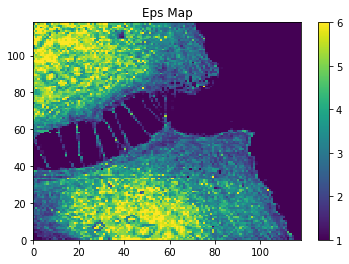

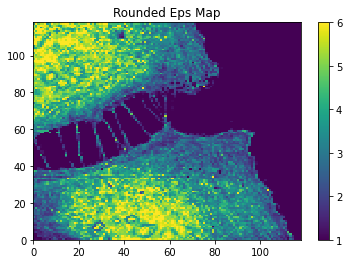

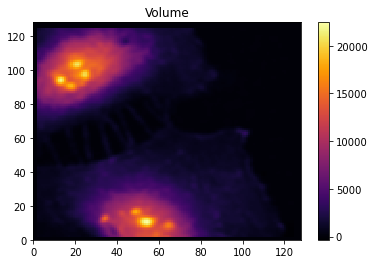

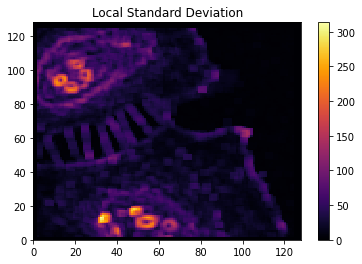

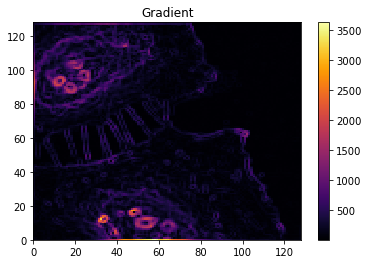

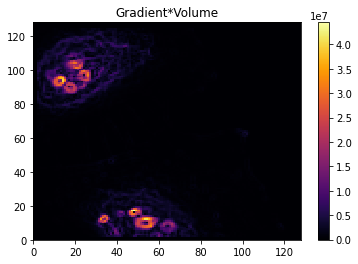

(13924,)
(118, 118)
Loading the data: 0%
Loading the data: 0%
Loading the data: 0%
Loading the data: 0%
Loading the data: 0%
Loading the data: 0%
Loading the data: 0%
Loading the data: 1%
Loading the data: 2%
Loading the data: 3%
Loading the data: 6%
Loading the data: 12%
Loading the data: 25%
Loading the data: 50%


In [2]:
#Definition of Parameters
ImageSizeX=128
ImageSizeY=128
header_list_pillar = ["Z", "VDef", "R","Height_2","Precision 6","Series Time","Segment Time"]
header_list_Bacteria = ["Z", "VDef", "R","Height_2","LockinAmp","LockinPh","Precision 6","Precision 7", "Precision 8","Series Time","Segment Time"]
header_list_cell = ["Z", "VDef", "R","Height_2","LockinAmp","LockinPh","Precision 12","Precision 6","Precision 7", "Precision 8","Series Time","Segment Time"]
Number_of_pixels=ImageSizeX*ImageSizeY
Points_at_contact=4

#Pixels_for_volume_has to be an even number that resembles
Pixels_for_volume=4
Pixel_size=1

#We read the file with the topo matrix and plot it
Path_topo = r'C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\EFM9 Topography Flattened.txt' 
topo=pd.read_table(Path_topo,header=None, sep='\t',skiprows=5)
topo=topo.values
f1=plt.figure()
plt.pcolormesh(topo)
plt.colorbar()
plt.show()

#We read the C' images
Path_C1 = r'C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\\C_50_EFM9.txt' 
C1=pd.read_table(Path_C1,header=None, sep='\t',skiprows=5)
C1=C1.values
f1=plt.figure()
plt.pcolormesh(C1)
plt.colorbar()
plt.show()

Path_C2 = r'C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\\C_71_EFM9.txt' 
C2=pd.read_table(Path_C2,header=None, sep='\t',skiprows=5)
C2=C2.values
f1=plt.figure()
plt.pcolormesh(C2)
plt.colorbar()
plt.show()

Path_C3 = r'C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\\C_110_EFM9.txt' 
C3=pd.read_table(Path_C3,header=None, sep='\t',skiprows=5)
C3=C3.values
f1=plt.figure()
plt.pcolormesh(C3)
plt.colorbar()
plt.show()

#Definition of Parameters EFM9
eps_ImageSizeX=118
eps_ImageSizeY=118
X_ini=5
X_fin=122
Y_ini=5
Y_fin=122
eps_Number_of_pixels=eps_ImageSizeX*eps_ImageSizeY
eps_map_vector=np.empty(eps_Number_of_pixels)

#We read the file with the EPSILON matrix
Path_eps = r'C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\\EFM9 epsmap.txt' 
eps_map=pd.read_table(Path_eps,header=None, sep='\t',skiprows=5)
eps_map=eps_map.values
f1=plt.figure()
plt.pcolormesh(eps_map)
plt.colorbar()
plt.clim(1,6) 
plt.title('Eps Map')
plt.show()

#We round the eps values
#eps_map=eps_map.round()
f6=plt.figure()
plt.pcolormesh(eps_map)
plt.colorbar()
plt.clim(1,6) 
plt.title('Rounded Eps Map')
plt.show()


#We define the function that calculates the area:
def double_Integral(xmin, xmax, ymin, ymax, nx, ny, A):
    dS = ((xmax-xmin)/(nx-1)) * ((ymax-ymin)/(ny-1))
    A_Internal = A[1:-1, 1:-1]
    # sides: up, down, left, right
    (A_u, A_d, A_l, A_r) = (A[0, 1:-1], A[-1, 1:-1], A[1:-1, 0], A[1:-1, -1])
    # corners
    (A_ul, A_ur, A_dl, A_dr) = (A[0, 0], A[0, -1], A[-1, 0], A[-1, -1])
    return dS * (np.sum(A_Internal)\
                + 0.5 * (np.sum(A_u) + np.sum(A_d) + np.sum(A_l) + np.sum(A_r))\
                + 0.25 * (A_ul + A_ur + A_dl + A_dr))

#We initialize the matrix with zeros and fill it with the volume probed:
V_probed=np.zeros((ImageSizeX,ImageSizeY))
std_probed=np.zeros((ImageSizeX,ImageSizeY))
Topo_probed=np.zeros((Pixels_for_volume,Pixels_for_volume))

for i in range(int(Pixels_for_volume/2),(ImageSizeX-1-int(Pixels_for_volume/2))):
        for j in range(int(Pixels_for_volume/2),(ImageSizeX-1-int(Pixels_for_volume/2))):
            Topo_probed=topo[i-int(Pixels_for_volume/2):i+int(Pixels_for_volume/2),j-int(Pixels_for_volume/2):j+int(Pixels_for_volume/2)]
            V_probed[i,j]=double_Integral(0,Pixels_for_volume*Pixel_size,0,Pixels_for_volume*Pixel_size,Pixels_for_volume,Pixels_for_volume,Topo_probed)
            std_probed[i,j]=np.std(Topo_probed)           
#We plot the Volume probed
f2=plt.figure()
plt.pcolormesh(V_probed,cmap='inferno')
plt.title('Volume')
plt.colorbar()
plt.show()    

#We plot the STD local 
f22=plt.figure()
plt.pcolormesh(std_probed,cmap='inferno')
plt.title('Local Standard Deviation')
plt.colorbar()
plt.show()   

#Now lets calculate the gradient of the image.

# Get x-gradient in "sx"
gradient_x = ndimage.sobel(topo,axis=0,mode='constant')
# Get y-gradient in "sy"
gradient_y = ndimage.sobel(topo,axis=1,mode='constant')
# Get square root of sum of squares
gradient=np.hypot(gradient_x,gradient_y)

#We plot the gradient
f3=plt.figure()
plt.pcolormesh(gradient,cmap='inferno')
plt.colorbar()
plt.title('Gradient')
#c
plt.show()    

#We plot the gradient*Volume Probed
f4=plt.figure()
plt.pcolormesh(np.multiply(gradient,V_probed),cmap='inferno')
plt.colorbar()
plt.title('Gradient*Volume')
#plt.clim(0,1.25e8) 
plt.show()   

topo_vector=np.empty(eps_Number_of_pixels)
gradient_vector=np.empty(eps_Number_of_pixels)
volume_vector=np.empty(eps_Number_of_pixels)
std_vector=np.empty(eps_Number_of_pixels)
eps_vector=np.empty(eps_Number_of_pixels)
C1_vector=np.empty(eps_Number_of_pixels)
C2_vector=np.empty(eps_Number_of_pixels)
C3_vector=np.empty(eps_Number_of_pixels)

print(eps_vector.shape)
print(eps_map.shape)

contador=0
for i in range(0,(Number_of_pixels-1)):  
    if i>0:
        if Number_of_pixels % i == 0:
            print('Loading the data: '+str(round(100*i/Number_of_pixels))+'%')

    xid=math.trunc(i/ImageSizeX)
    yid=i-ImageSizeX*math.trunc(i/ImageSizeX)
  
#We fill the 1D vectors of the additional images
    
    if(xid >= X_ini and  xid <= X_fin and (ImageSizeY-1-yid)>=Y_ini and (ImageSizeY-1-yid)<=Y_fin):
        eps_vector[contador]=eps_map[xid-X_ini,ImageSizeY-1-yid-Y_ini]
        topo_vector[contador]=topo[xid,ImageSizeY-1-yid]
        gradient_vector[contador]=gradient[xid,ImageSizeY-1-yid]
        volume_vector[contador]=V_probed[xid,ImageSizeY-1-yid]
        std_vector[contador]=std_probed[xid,ImageSizeY-1-yid]
        C1_vector[contador]=C1[xid,ImageSizeY-1-yid]
        C2_vector[contador]=C2[xid,ImageSizeY-1-yid]
        C3_vector[contador]=C3[xid,ImageSizeY-1-yid]     
        contador=contador+1

## Prepare the imported data for the NN

In [4]:
from sklearn.preprocessing import StandardScaler

eps_vector_nometal=eps_vector[(eps_vector>1)]
topo_vector_nometal=topo_vector[(eps_vector>1)]
volume_vector_nometal=volume_vector[(eps_vector>1)]
std_vector_nometal=std_vector[(eps_vector>1)]
gradient_vector_nometal=gradient_vector[(eps_vector>1)]
C1_nometal=C1_vector[(eps_vector>1)]
C2_nometal=C2_vector[(eps_vector>1)]
C3_nometal=C3_vector[(eps_vector>1)]

Number_of_pixels_nometal=len(eps_vector_nometal)

#We add all the data to the matrix to be classified
data_for_NN=np.column_stack((C1_vector,C2_vector,C3_vector,topo_vector,volume_vector,std_vector))
data_for_NN_nometal=np.column_stack((C1_nometal,C2_nometal,C3_nometal,topo_vector_nometal,volume_vector_nometal,std_vector_nometal))

#We preprocess all the data for the features to be normalized
scaler = StandardScaler()
scaler.fit(data_for_NN)
Normalized_Data = scaler.transform(data_for_NN)

scaler = StandardScaler()
scaler.fit(data_for_NN_nometal)
Normalized_Data_nometal = scaler.transform(data_for_NN_nometal)

#print(Normalized_Data)
#print(Normalized_Data_nometal)

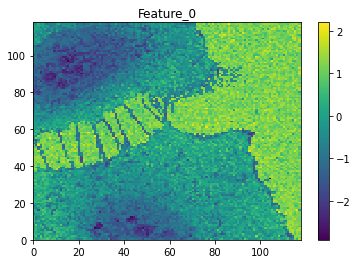

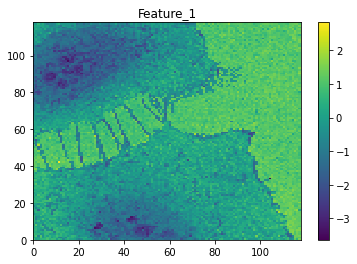

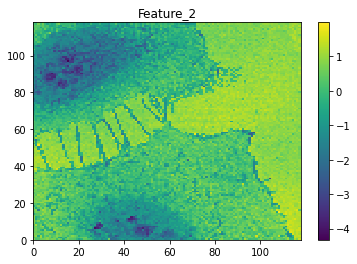

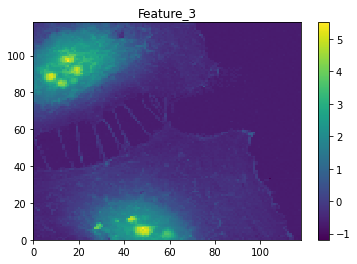

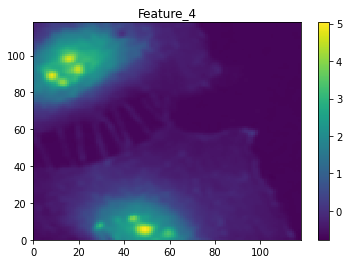

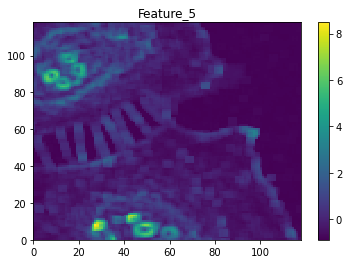

In [5]:
#Plot the input features after normalization
for i in range (0,6):
    feature_normalized=Normalized_Data[:,i]
    feature_normalized = np.reshape(feature_normalized,(eps_ImageSizeX,eps_ImageSizeY))
    feature_normalized=np.fliplr(feature_normalized)
        
    f87=plt.figure()
    plt.pcolormesh(feature_normalized)
    plt.colorbar()
    plt.title('Feature_'+str(i)) 
    plt.show() 

## Perform the Multy Layer Perceptron regressor

The accuracy of the model is:
0.891954619785744


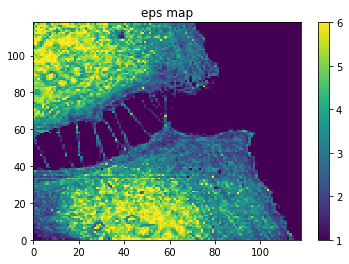

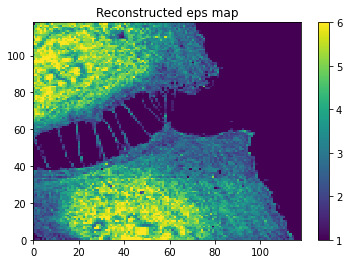

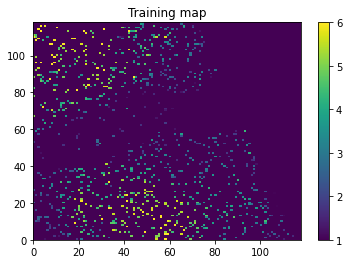

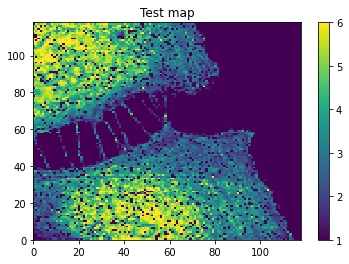

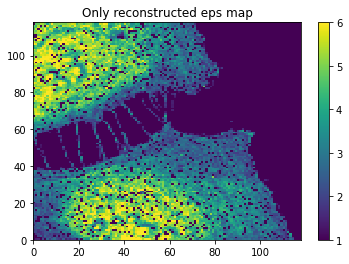

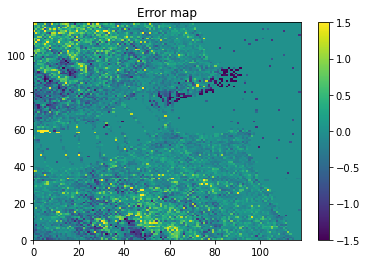

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
import os
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# We now start the NNN algorithm for classification
sss = ShuffleSplit(n_splits=1, test_size=0.90)
sss.get_n_splits(Normalized_Data_nometal, eps_vector_nometal)
train_index, test_index = next(sss.split(Normalized_Data_nometal, eps_vector_nometal)) 
train_index=np.sort(train_index)  
test_index=np.sort(test_index)   
X_train, X_test = Normalized_Data_nometal[train_index], Normalized_Data_nometal[test_index] 
y_train, y_test = eps_vector_nometal[train_index], eps_vector_nometal[test_index]

# We train the model
regr = MLPRegressor(random_state=1,max_iter=2000).fit(X_train, y_train)
prediction=regr.predict(X_test)
print("The accuracy of the model is:")
print(regr.score(X_test, y_test))

# We classify the test data:
reconstructed_eps_map=np.zeros(eps_Number_of_pixels)
only_reconstructed_eps_map=np.zeros(eps_Number_of_pixels)
training_map=np.zeros(eps_Number_of_pixels)
test_map=np.zeros(eps_Number_of_pixels)

cont_metal=0
cont_train=0
cont_test=0
for i in range(0,(eps_Number_of_pixels-1)):
    
    if (eps_vector[i]<=1):
        reconstructed_eps_map[i]=1
        only_reconstructed_eps_map[i]=0
        test_map[i]=0
        training_map[i]=0
    else:

        if(np.isin(cont_metal, train_index)==True):
            reconstructed_eps_map[i]=y_train[cont_train]
            only_reconstructed_eps_map[i]=0
            test_map[i]=0
            training_map[i]=y_train[cont_train]
            cont_train=cont_train+1
            cont_metal=cont_metal+1
            
        elif(np.isin(cont_metal, test_index)==True):
            reconstructed_eps_map[i]=prediction[cont_test]
            only_reconstructed_eps_map[i]=prediction[cont_test]
            test_map[i]=y_test[cont_test]
            training_map[i]=0
            cont_test=cont_test+1
            cont_metal=cont_metal+1

reconstructed_eps_map = np.reshape(reconstructed_eps_map,(eps_ImageSizeX,eps_ImageSizeY))
only_reconstructed_eps_map = np.reshape(only_reconstructed_eps_map,(eps_ImageSizeX,eps_ImageSizeY))
training_map = np.reshape(training_map,(eps_ImageSizeX,eps_ImageSizeY))
test_map = np.reshape(test_map,(eps_ImageSizeX,eps_ImageSizeY))

reconstructed_eps_map=np.fliplr(reconstructed_eps_map)
only_reconstructed_eps_map=np.fliplr(only_reconstructed_eps_map)
training_map=np.fliplr(training_map)
test_map=np.fliplr(test_map)

#print(reconstructed_eps_map.shape)
#print(training_map.shape)
        
f20=plt.figure()
plt.pcolormesh(eps_map)
plt.colorbar()
plt.title('eps map')
plt.clim(1,6) 
plt.show()  

f22=plt.figure()
plt.pcolormesh(reconstructed_eps_map)
plt.colorbar()
plt.title('Reconstructed eps map')
plt.clim(1,6) 
plt.show() 

f22=plt.figure()
plt.pcolormesh(training_map)
plt.colorbar()
plt.title('Training map')
plt.clim(1,6) 
plt.show() 

f23=plt.figure()
plt.pcolormesh(test_map)
plt.colorbar()
plt.title('Test map')
plt.clim(1,6) 
plt.show() 

f24=plt.figure()
plt.pcolormesh(only_reconstructed_eps_map)
plt.colorbar()
plt.title('Only reconstructed eps map')
plt.clim(1,6) 
plt.show() 

error_map=np.subtract(eps_map,reconstructed_eps_map)

f22=plt.figure()
plt.pcolormesh(error_map)
plt.colorbar()
plt.title('Error map')
plt.clim(-1.5,1.5) 
plt.show() 


## Save generated images

In [11]:
#We save the images if wanted
os.chdir(r'C:\Users\3un\Desktop\Jupyter Notebooks\Github notebooks\Data for them\Saves images')
np.savetxt("training_map_10_100_EFM9.txt", training_map , delimiter = ",")
np.savetxt("test_map_10_100_EFM9.txt", test_map , delimiter = ",")
np.savetxt("reconstructed_map_10_100_EFM9.txt", reconstructed_eps_map , delimiter = ",")
np.savetxt("only_reconstructed_map_10_100_EFM9.txt", only_reconstructed_eps_map , delimiter = ",")
np.savetxt("error_map_10_100_EFM9.txt", error_map , delimiter = ",")

## Error as a function of the trainin size

In [ ]:
#MODEL ACCURACY AS A FUNCTION OF TRAINING SIZE
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
import os
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

number_of_loops=2
test_sises=np.zeros((number_of_loops,100))
scoress=np.zeros((number_of_loops,100))

for j in range(1,number_of_loops):   
    for i in range(1,100):
        if i % 10 == 0:
            print('Calculating Error...', i, '%')
# We now start the NNN algorithm for classification
        sss = ShuffleSplit(n_splits=1, test_size=1-(i*0.001))
        sss.get_n_splits(Normalized_Data_nometal, eps_vector_nometal)
        train_index, test_index = next(sss.split(Normalized_Data_nometal, eps_vector_nometal)) 
        train_index=np.sort(train_index)  
        test_index=np.sort(test_index)   
        X_train, X_test = Normalized_Data_nometal[train_index], Normalized_Data_nometal[test_index] 
        y_train, y_test = eps_vector_nometal[train_index], eps_vector_nometal[test_index]

# We train the model
        regr = MLPRegressor(random_state=1,max_iter=2000).fit(X_train, y_train)
        prediction=regr.predict(X_test)
        #print(regr.score(X_test, y_test))
        test_sises[j,i]=i*(0.001)
        scoress[j,i]=regr.score(X_test, y_test)

f28=plt.figure()
for j in range(1,number_of_loops):
    plt.plot(test_sises[j,:],scoress[j,:], marker='o')
plt.xlabel('train size')
plt.ylabel('Score')
plt.title('Model score vs training size')
plt.show() 

Calculating Error... 10 %
Calculating Error... 20 %
Calculating Error... 30 %
Calculating Error... 40 %
Calculating Error... 50 %
Calculating Error... 60 %
Calculating Error... 70 %
Calculating Error... 80 %
